# Advanced Statistical Analysis of Health Expenditure (2000-2020)

Following exploratory data analysis, this notebook analyzes health expenditure trends for 192 countries over two decades. It includes: 
- **OLS & Hypothesis Testing**: Baseline regressions to estimate relationships between key variables.
- **Ridge Regression**: Regularized model to predict life expectancy using multivariate health and economic indicators.
- **Time Series Forecasting (ARIMA)**: Modeled global trends in health expenditure using aggregated anual data.
- **Panel Regression (Fixed and Random Effects)**: Estimated within-country effects over time and validated model choice using the Hausman Test.

## Key findings from EDA & Impact on Modeling
## 1. Descriptive Statistics Calculations: Variability in Health Expenditure
- Large disparities in **CHE (current health expenditure) per capita** across countries.
- **Life Expectancy** showed a steady upward trend but at different rates. 

**Impact**: Justified the need for **time-series forecasting (ARIMA)** to capture temporal trends and predict future trajectories.

## 2. Correlation Analysis: Understanding Key Relationships
- **CHE per capita** and **Life Expectancy** showed a strong positive correlation. 
- **GDP per capita** was highly correlated with health spending.
- **Under-5 mortality** was inversely related to healthcare investment.

**Impact**: Informed feature selection for **regression models**, especially Ridge and panel regression.

## 3. Clustering Analysis: Identifying Country Groups
- **K-Means clustering** revealed distinct economic and health-based country groups. 
- Countries clustered into **high-income, middle-income, and low-income** groups based on **GDP per capita, CHE, and Life Expectancy**.

**Impact**: Reinforced the need to account for **country-specific characteristics** in modeling. This informed the use of **Fixed Effects pannel regression**, which captures unobserved heterogeneity across countries.

## 4. Data Cleaning and Handling: Dealing with Missing Values and Duplicates
- Missing values were imputed, and duplicate records were averaged for consistency.
- Time and entity structure established for panel modeling.

**Impact**: Enabled smooth transformation to panel format for regression and ARIMA modeling.

This foundation sets the stage for robust statistical modeling and interactive visualizations, including **regional dashboards in Tableau** that will help translate these findings into actionable insights.

In [19]:
# Load dependencies 
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import seaborn as sns

## 1. Connect to PostgresSQL database and fetch data 

Connect to the database and extract relevant indicators for analysis.

In [21]:
# Database connection parameters 
db_params = {
    "dbname": "health_data",
    "user": "postgres",
    "password": "what",
    "host": "localhost",
    "port": 5432
}

# Function to establish connection
def connect_to_db(params):
    try: 
        conn = psycopg2.connect(**params)
        print("Database connection successful!")
        return conn
    except Exception as e:
        print(f"Error: {e}")
        return None

# Query function
def fetch_data(query):
    conn = connect_to_db(db_params)
    if not conn:
        return None
    try:
        df = pd.read_sql(query, conn)
        print("Data fetched successfully!")
        return df
    except Exception as e:
        print(f"Error: {e}")
        return None
    finally:
        conn.close()

# Query data
query = """
SELECT country_id, year, indicator_id, value 
FROM health_metrics.health_data 
WHERE indicator_id IN (1,3,6,7,9,18,19)
"""

df = fetch_data(query)
df.head()  # Display first few rows

# Load country metadata from Postgres
countries_query = "SELECT * FROM health_metrics.countries"
countries_df = fetch_data(countries_query)

# Helper function: Rename indicator_id columns after pivot 
def rename_indicators(df_pivot, rename_dict=None):
    if rename_dict is None:
        rename_dict = {
            1: "gdp",
            3: "che_total",
            6: "gdp_per_capita",
            7: "che_per_capita",
            9: "oops_per_capita",
            18: "life_expectancy",
            19: "under_5_mortality"
        }
    return df_pivot.rename(columns=rename_dict)


Database connection successful!
Data fetched successfully!
Database connection successful!
Data fetched successfully!


/var/folders/7r/4rng20_d3078xb_q6_2l1ll40000gn/T/ipykernel_47355/2656471314.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


## 2. Data Preprocessing 

Convert 'year' column to a datetime format, set it as an index, and prepare time-series data.

In [22]:
# Check for column name issues
df.columns = df.columns.str.strip()  # Remove any leading/trailing spaces

print(f"Column Names: {df.columns.tolist()}")
print(f"First few rows:\n{df.head()}")

# Ensure "year" is present
if "year" not in df.columns:
    print("Error: 'year' column is missing! Check SQL query and column names.")
else:
    # Convert "year" to datetime format
    df["year"] = pd.to_datetime(df["year"], format="%Y")

    # Reset index to ensure "year" is a column
    df.reset_index(inplace=True, drop=True)

    # Handle missing values before pivoting
    df.dropna(subset=["value"], inplace=True)  # Remove rows where 'value' is NaN

    # Pivot for easier analysis
    try:
        df_pivot = df.pivot(index=["country_id", "year"], columns="indicator_id", values="value")
        print("Pivot table created successfully!")
    except KeyError as e:
        print(f"Pivoting failed: {e}")
        print("Check if 'year' and 'country_id' are correctly formatted.")

# Rename indicators after pivot
df_pivot = rename_indicators(df_pivot)

print(df_pivot.head())  # Preview results


Column Names: ['country_id', 'year', 'indicator_id', 'value']
First few rows:
   country_id  year  indicator_id       value
0         278  2000             3         NaN
1         278  2000             1         NaN
2         300  2000             3   207.30903
3         300  2000             1  3487.58635
4         196  2000             3  1911.64847
Pivot table created successfully!
indicator_id                   gdp    che_total  gdp_per_capita  \
country_id year                                                   
196        2000-01-01  59462.98682  1911.648470     1924.126122   
           2001-01-01  59413.40105  2101.027609     1896.300183   
           2002-01-01  61516.10341  2117.197412     1937.464145   
           2003-01-01  73482.27711  2443.795406     2283.773431   
           2004-01-01  91913.61721  3024.238523     2816.991895   

indicator_id           che_per_capita  oops_per_capita  life_expectancy  \
country_id year                                                    

## 3. Hypothesis Testing 

Apply **Ordinary Least Squares (OLS)** to determine which factors significantly impact life expectancy prior to training predictive models.

## Why OLS? 
- **Statistical Inference**: Unlike Ridge Regression, which is optimized for **minmizing prediction errors**, OLS provides **p-values** and **confidence intervals** for each coefficient. This helps assess **statistical significance** of predictor variables.
- **Hypothesis Testing**: OLS allows us to test whether a given variable hasa meaningful effect on the target variable (**life expectancy**) or if its observed impact is due to chance. 
- **Baseline Model**: It serves as a fundamental method to understand relationships between variables before applying complex techniques.

Using p-values to assess significance: 
- **p < 0.05** - Statistically significant (keep in model).
- **p >= 0.05** - Not statistically significant (consider dropping from model).

In [23]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# Define independent (X) and target (y) variables 
X = df_pivot[["gdp", "che_total", "gdp_per_capita", "che_per_capita", "oops_per_capita", "under_5_mortality"]]
y = df_pivot["life_expectancy"]

# Standardize features before OLS method
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert standardized X values to DataFrame 
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Check for missing and infinite values 
print("Missing values in X_scaled before cleaning:\n", X_scaled.isna().sum())
print("Missing values in y before cleaning:\n", y.isna().sum())

print("\nInfinite values in X_scaled:", np.isinf(X_scaled).sum().sum())

# Check data integrity 
print(f"X_scaled shape: {X_scaled.shape}")
print(f"y shape: {y.shape}")

if X_scaled.shape[0] == 0 or y.shape[0] == 0:
    raise ValueError("Error: After cleaning, X or y is empty. Investigate data cleaning steps.")

# Handle missing values 
drop_missing = True 

if drop_missing: 
    print("Dropping missing values...")
    X_scaled.dropna(inplace=True)
    y = y.loc[X_scaled.index]
    y.dropna(inplace=True)
else:
    print("Imputing missing values with column means...")
    X_scaled.fillna(X_scaled.mean(), inplace=True)
    y.fillna(y.mean(), inplace=True)

# Check data integrity again after cleaning
print(f"After handling missing values - X_scaled shape: {X_scaled.shape}, y shape: {y.shape}")

# Final check for any remaining NaNs 
print("Final check - Missing values in X_scaled:\n",X_scaled.isna().sum().sum())
print("Final check - Missing values in y:\n", y.isna().sum())

# Check for constant columns (no variance)
constant_columns = X_scaled.columns[X_scaled.nunique() <= 1]
if len(constant_columns) > 0:
    print(f"Dropping constant columns: {constant_columns.tolist()}")
    X_scaled.drop(columns=constant_columns, inplace=True)

# Ensure y has variablity 
print("Unique values in y:", y.nunique())
if y.nunique() <= 1: 
    raise ValueError("Error: The dependent variable (y) has only one unique value, OLS cannot run.")


Missing values in X_scaled before cleaning:
 indicator_id
gdp                  77
che_total            77
gdp_per_capita       77
che_per_capita       77
oops_per_capita      77
under_5_mortality     0
dtype: int64
Missing values in y before cleaning:
 232

Infinite values in X_scaled: 0
X_scaled shape: (4074, 6)
y shape: (4074,)
Dropping missing values...
After handling missing values - X_scaled shape: (3997, 6), y shape: (3765,)
Final check - Missing values in X_scaled:
 0
Final check - Missing values in y:
 0
Unique values in y: 2172


In [24]:
# Ensure X and y are aligned 
X_scaled, y = X_scaled.align(y, join="inner", axis=0)

# Add intercept to the independent variables
X_with_intercept = sm.add_constant(X_scaled)

# Fit OLS Regression Model
ols_model = sm.OLS(y, X_with_intercept).fit()

# Display Coefficients & P-values
print("\nOLS Regression Results:\n")
print(ols_model.summary())

# Select only statistically significant features
sig_features = list(ols_model.pvalues[ols_model.pvalues < 0.05].index)

# Remove intercept from significant features if present 
if 'const' in sig_features:
    sig_features.remove('const')

print(f"Significant Features selected: {sig_features}")


OLS Regression Results:

                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     2920.
Date:                Thu, 15 May 2025   Prob (F-statistic):               0.00
Time:                        16:55:45   Log-Likelihood:                -10295.
No. Observations:                3765   AIC:                         2.060e+04
Df Residuals:                    3758   BIC:                         2.065e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const       

             Feature        VIF
0                gdp   8.609952
1          che_total   9.430108
2     gdp_per_capita   7.616793
3     che_per_capita  14.854382
4    oops_per_capita   6.500068
5  under_5_mortality   1.310249

High Multicollinearity detected - consider removing these features:
           Feature        VIF
0              gdp   8.609952
1        che_total   9.430108
2   gdp_per_capita   7.616793
3   che_per_capita  14.854382
4  oops_per_capita   6.500068


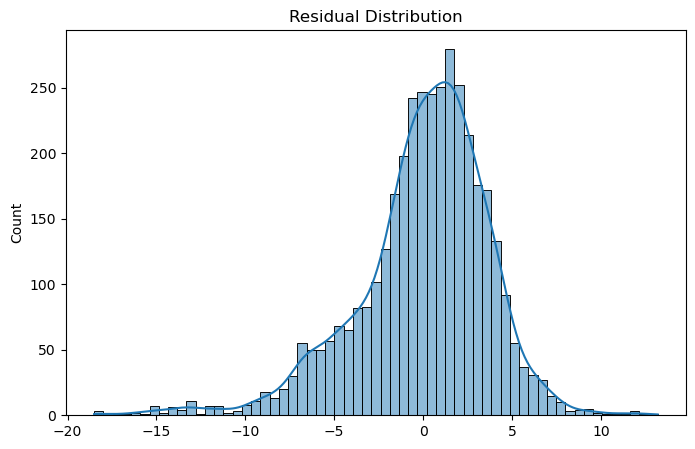


Durbin-Watson Score: 0.13722950798693384
Possible autocorrelation detected. Consider using time-series methods.


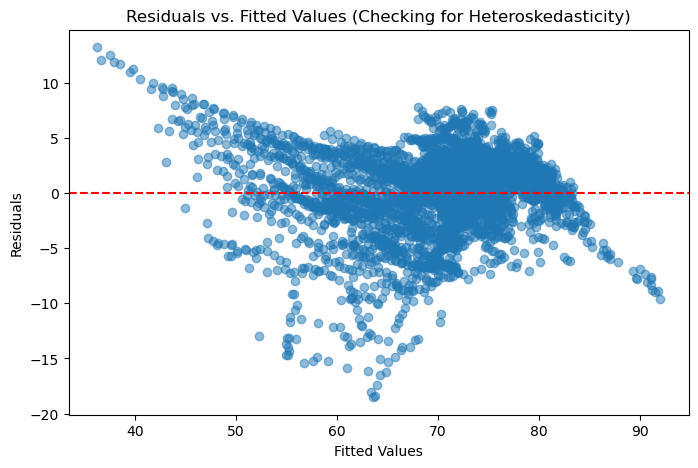


Diagnostics checks complete - review outputs for any issues.


In [25]:
# Check for multicollinearity (VIF Test)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson

# Compute VIF for each variable 
vif_data = pd.DataFrame()
vif_data["Feature"] = X_scaled.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]
print(vif_data)

# Flagging high VIF features 
high_vif = vif_data[vif_data["VIF"] > 5]
if not high_vif.empty: 
    print(f"\nHigh Multicollinearity detected - consider removing these features:\n{high_vif}")

# Check for normality of residuals 
residuals = ols_model.resid

plt.figure(figsize=(8,5))
sns.histplot(residuals,kde=True)
plt.title("Residual Distribution")
plt.show()

# Check for autocorrelation 
dw_value = durbin_watson(ols_model.resid)
print(f"\nDurbin-Watson Score: {dw_value}")
if dw_value < 1.5 or dw_value > 2.5: 
    print("Possible autocorrelation detected. Consider using time-series methods.")

# Check for heteroskedasticity (variance of residuals)
plt.figure(figsize=(8,5))
plt.scatter(ols_model.fittedvalues, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='dashed')
plt.title("Residuals vs. Fitted Values (Checking for Heteroskedasticity)")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

print("\nDiagnostics checks complete - review outputs for any issues.")

## 4. Ridge Regression for Health Outcome Predictions

Predict **Life Expectancy** based on **statistically significant** health expenditure indicators.

Note: Ridge Regression models account for high multicollinearity, and so we are also testing to see whether the above diagnostics tests will be resolved. We will try **three** different approaches:
1. Regression with all features intact
2. Regression applying features with VIF Score < 10 and refined hyperparameter (**alpha**)
3. Regression applying PCA (Principal Component Analysis) - decorrelate features.

In [26]:
# Approach 1 - Ridge Regression (All Features)

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Remove intercept if present
if 'const' in sig_features:
    sig_features.remove('const')

# Subset the data based on significant features 
X_selected = df_pivot[sig_features]

# Align X and y to ensure same number of rows
X_selected, y = X_selected.align(y, join="inner", axis=0)

# Standardize features 
scaler = StandardScaler()
X_scaled_selected = scaler.fit_transform(X_selected)

# # Apply log transformation to address heteroskedasticity (if needed)
# X_transformed = X_selected.copy()
# for col in sig_features:
#     if X_selected[col].skew() > 1:
#         X_transformed[col] = np.log1p(X_selected[col])

# X_scaled_transformed = scaler.fit_transform(X_transformed)

# Train Ridge Regression 
X_train, X_test, y_train, y_test = train_test_split(X_scaled_selected, y, test_size=0.2, random_state=42)

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

# Evaluate Ridge Regression Performance 
y_pred = ridge_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nRidge Regression Results (All Features):")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R2 Score: {r2:.4f}")

# Cross Validation 
ridge_cv_scores = cross_val_score(ridge_model,X_scaled_selected, y, cv=5, scoring='r2')
print(f"Cross-Validation R2 Scores: {ridge_cv_scores}")
print(f"Mean R2 Score: {ridge_cv_scores.mean():.4f}")


Ridge Regression Results (All Features):
Mean Squared Error (MSE): 12.5545
R2 Score: 0.8450
Cross-Validation R2 Scores: [ 0.33410563  0.76752303 -0.08366969  0.51321383  0.72596062]
Mean R2 Score: 0.4514


In [27]:
# Determining Optimal Alpha 
from sklearn.linear_model import RidgeCV

# Define a range of alpha values to test 
alphas = [0.1, 1.0, 10, 100, 500]

# Perform Ridge Regression with cross-validation
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X_train, y_train)

# Print optimal alpha 
print(f"Optima alpha: {ridge_cv.alpha_}")

Optima alpha: 10.0


/Users/sandyagustines/anaconda3/envs/new_analysis_env/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


In [28]:
# Approach 2 - Regression (VIF Filtering - remove features with VIF > 10)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Using previous calculation, calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_scaled.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]
print(vif_data)

# Flagging high VIF Features (VIF > 10)
high_vif = vif_data[vif_data["VIF"] > 10]
if not high_vif.empty:
    print(f"High multicollinearity detected - consider removing these variables that have VIF > 10")

# Remove high VIF features from X 
high_vif_features = ["che_per_capita"] # Features with VIF > 10
X_filtered = X_selected.drop(columns=high_vif_features)

# Standardize the data 
scaler = StandardScaler()
X_scaled_filtered = scaler.fit_transform(X_filtered)

# Train regression with filtered features 
X_train, X_test, y_train, y_test = train_test_split(X_scaled_filtered, y, test_size=0.2, random_state=42)

# Using the optimal alpha we found previously, fit the model 
ridge_model = Ridge(alpha=10.0)
ridge_model.fit(X_train, y_train)

# Evaluate model performance 
y_pred = ridge_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n Ridge Regression Results (Filtered):")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-Squared (R2): {r2:.4f}")

# Cross Validation
ridge_cv_scores = cross_val_score(ridge_model, X_scaled_filtered, y, cv=5, scoring="r2")
print(f"Cross-Validation R2 Scores: {ridge_cv_scores}")
print(f"Mean R2 Score: {ridge_cv_scores.mean():.4f}")




             Feature        VIF
0                gdp   8.609952
1          che_total   9.430108
2     gdp_per_capita   7.616793
3     che_per_capita  14.854382
4    oops_per_capita   6.500068
5  under_5_mortality   1.310249
High multicollinearity detected - consider removing these variables that have VIF > 10

 Ridge Regression Results (Filtered):
Mean Squared Error (MSE): 12.5845
R-Squared (R2): 0.8446
Cross-Validation R2 Scores: [0.33478583 0.76761435 0.35846654 0.51201877 0.74779177]
Mean R2 Score: 0.5441


In [29]:
# Approach 3 - Applying PCA

from sklearn.decomposition import PCA

# Apply PCA 
pca = PCA(n_components=0.95) # Retain 95% variance 
X_pca = pca.fit_transform(X_scaled_filtered)

# Check number of components retained 
print(f"Number of Principal Components Retained: {pca.n_components_}")

# Train regression using PCA features
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

ridge_pca = Ridge(alpha=10.0)
ridge_pca.fit(X_train, y_train)

# Evaluate PCA-Based Ridge model 
y_pred = ridge_pca.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n PCA + Ridge Regression Results:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-Squared (R2): {r2:.4f}")

# Cross-Validation
ridge_cv_scores = cross_val_score(ridge_pca, X_pca, y, cv=5, scoring="r2")
print(f"Cross-Validation R2 Scores: {ridge_cv_scores}")
print(f"Mean R2 Score: {ridge_cv_scores.mean():.4f}")

Number of Principal Components Retained: 3

 PCA + Ridge Regression Results:
Mean Squared Error (MSE): 12.8088
R-Squared (R2): 0.8418
Cross-Validation R2 Scores: [0.32528258 0.76675869 0.50707125 0.58384709 0.752377  ]
Mean R2 Score: 0.5871


## 5. Time Series Forecasting 

Use ARIMA to predict future trends in:  
- **CHE (Current Health Expenditure)**: future healthcare spending is expected to follow an increasing treend, reinforcing the importance of budget panning for sustainable health financing.

## Why ARIMA?
The **AutoRegressive Integrated Moving Average (ARIMA)** model is a widely used method for forecasting time-series data.  It accounts for: 
- **AutoRegression (AR)**: relationship between past and future values. 
- **Integration (I)**: differencing to achieve stationarity. 
- **Moving Average (MA)**: dependence on past forecast errors. 

## Key Findings from OLS and Ridge Regression: 
- GDP, CHE Total, GDP per Capita, OOPS per Capita and Under-5 Mortality were statistically significant in predicting Life Expectancy from OLS. 
- CHE per Capita had high VIF (> 10), indicating strong correlation with other features, and thus was removed from Ridge. 

In [30]:
# Check "year" column exists before pivoting 
print("Columns in df before pivoting:", df.columns)

if "year" not in df.columns:
        raise ValueError("Error: 'year' column is missing! Check SQL query.")

# Convert "year" to datetime format (before pivoting)
df["year"] = pd.to_datetime(df["year"], format="%Y", errors="coerce")

# Drop missing values in the "value" column before pivoting 
df.dropna(subset=["value"], inplace=True)

# Confirm year values 
print("First few rows of df before pivoting:")
print(df.head())

# Pivot with "year" as the first index 
df_pivot = df.pivot(index=["year", "country_id"], columns="indicator_id", values="value")

# Reset index to bring "year" and "country_id" back as columns
df_pivot.reset_index(inplace=True)

# Check if "year" is present
print("Columns in df_pivot after reset:", df_pivot.columns)

# Create a separate DataFrame for ARIMA
df_arima = df_pivot.copy()

# Set "year" as the final index (removing "country_id")
df_arima.set_index("year", inplace=True)

# Rename columns
df_arima = rename_indicators(df_arima)

# Set frequency for time series 
df_arima = df_arima.resample("YE").mean() # Aggregate data yearly 

# Set frequency and resample for time series 
df_arima.fillna(method="ffill", inplace=True)  # Prevent missing value drops
df_arima = df_arima.resample("YE").mean() # Aggregate data yearly

print("Columns after resampling:", df_arima.columns)

# Select CHE Total for forecasting 
che_total_series = df_arima["che_total"].dropna()

# Select Life Expectancy for forecasting 
life_expectancy_series = df_arima["life_expectancy"].dropna()


Columns in df before pivoting: Index(['country_id', 'year', 'indicator_id', 'value'], dtype='object')
First few rows of df before pivoting:
   country_id       year  indicator_id         value
2         300 2000-01-01             3    207.309030
3         300 2000-01-01             1   3487.586350
4         196 2000-01-01             3   1911.648470
5         196 2000-01-01             1  59462.986820
6         301 2000-01-01             3     85.067663
Columns in df_pivot after reset: Index(['year', 'country_id', 1, 3, 6, 7, 9, 18, 19], dtype='object', name='indicator_id')
Columns after resampling: Index(['country_id', 'gdp', 'che_total', 'gdp_per_capita', 'che_per_capita',
       'oops_per_capita', 'life_expectancy', 'under_5_mortality'],
      dtype='object', name='indicator_id')


/var/folders/7r/4rng20_d3078xb_q6_2l1ll40000gn/T/ipykernel_47355/1056399333.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_arima.fillna(method="ffill", inplace=True)  # Prevent missing value drops


In [31]:
from statsmodels.tsa.stattools import adfuller

# Check data stationarity
def check_stationarity(series, name):
    result = adfuller(series.dropna())
    print(f"Augmented Dickey-Fuller (ADF) Test Results for {name}:")
    print(f"ADF Statistic: {result[0]}")
    print(f"P-Value: {result[1]}")
    print("Stationary" if result[1] < 0.05 else "Non-stationary")

# Check stationarity for both time series 
check_stationarity(che_total_series, "CHE Total")
check_stationarity(life_expectancy_series, "Life Expectancy")


Augmented Dickey-Fuller (ADF) Test Results for CHE Total:
ADF Statistic: -0.29329421943152095
P-Value: 0.926448716500471
Non-stationary
Augmented Dickey-Fuller (ADF) Test Results for Life Expectancy:
ADF Statistic: -2.8271089588751224
P-Value: 0.05450456869117696
Non-stationary


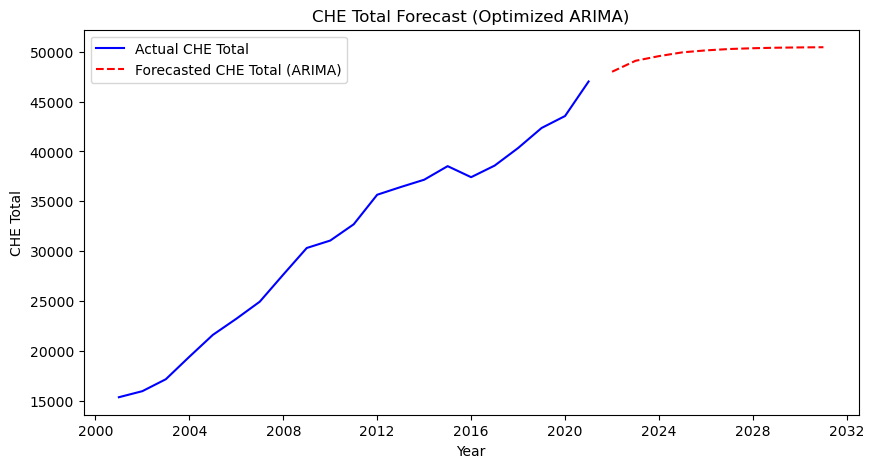

In [32]:
from statsmodels.tsa.arima.model import ARIMA

# # Fit ARIMA model for CHE Total 
che_model_opt = ARIMA(che_total_series, order=(2,1,0))
che_model_fit_opt = che_model_opt.fit()

# Forecast future values 
che_forecast_opt = che_model_fit_opt.forecast(steps=10)

# # Plot results 
plt.figure(figsize=(10,5))
plt.plot(che_total_series, label="Actual CHE Total", color="blue")
plt.plot(pd.date_range(che_total_series.index[-1], periods=11, freq="YE")[1:], che_forecast_opt, 
         label="Forecasted CHE Total (ARIMA)", linestyle="dashed", color="red")
plt.legend()
plt.title("CHE Total Forecast (Optimized ARIMA)")
plt.xlabel("Year")
plt.ylabel("CHE Total")
plt.show()

## 6. Panel Regression (Fixed and Random Effects)
In this section, we use panel data regression to assess how health expenditure and economic indicators influence life expectancy across countries over time.

### Methodology 
We apply a **Fixed Effects (FE) panel regression** model using the `PanelOLS` method from the `linearmodels` library. The panel format allows us to control for unobserved, time-invariant country-specific effects (e.g. culture, baseline health infrastructure).

Our dependent variable is **`life_expectancy`** and the explanatory variables include: 
- **`che_total`**: Current Health Expenditure (CHE) 
- **`gdp_per_capita`**: Economic prosperity of the population 
- **`under_5_mortality`**: Used as a proxy for overall health system effectiveness 

The dataset was pivoted and renamed using a helper function (`rename_indicators`) that standardizes indicator IDs into descriptive column names. After filtering for complete records, the data was formatted into a multi-index panel (by `country_id` and `year`) for regression modeling. 

We also estimate a **Random Effects (RE)** model and perform a **Hausman Test** to assess whether FE or RE is more appropriate for this dataset. This approach strengthens our ability to infer the impact of health and economic variables on life expectancy while accounting for structural differences across countries.


In [33]:
from linearmodels.panel import PanelOLS

# Apply rename function for column names 
df_pivot = rename_indicators(df_pivot)

# Reset index if using MultiIndex 
df_panel = df_pivot.reset_index()

# Select variables for panel regression 
panel_vars = ["country_id", "year", "life_expectancy", "che_total", "gdp_per_capita", "under_5_mortality"]
df_panel_clean = df_panel[panel_vars].dropna()

# Set index to (country_id, year) for panel format 
df_panel_clean = df_panel_clean.set_index(["country_id", "year"])

In [34]:
# Define X and y 
y = df_panel_clean["life_expectancy"]
X = df_panel_clean[["che_total", "gdp_per_capita", "under_5_mortality"]]

# Fit model for Fixed Effects (Entity Effects)
model_fe = PanelOLS(y, X, entity_effects=True)
results_fe = model_fe.fit()
print(results_fe.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:        life_expectancy   R-squared:                        0.7475
Estimator:                   PanelOLS   R-squared (Between):             -0.0920
No. Observations:                3765   R-squared (Within):               0.7475
Date:                Thu, May 15 2025   R-squared (Overall):             -0.0901
Time:                        16:56:14   Log-likelihood                   -6038.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      3531.9
Entities:                         183   P-value                           0.0000
Avg Obs:                       20.574   Distribution:                  F(3,3579)
Min Obs:                       3.0000                                           
Max Obs:                       21.000   F-statistic (robust):             3531.9
                            

In [35]:
from linearmodels.panel import RandomEffects

# Use same X and y from FE model to assess Random Effects
model_re = RandomEffects(y, X)
results_re = model_re.fit()
print(results_re.summary)


                        RandomEffects Estimation Summary                        
Dep. Variable:        life_expectancy   R-squared:                        0.7131
Estimator:              RandomEffects   R-squared (Between):             -0.0908
No. Observations:                3765   R-squared (Within):               0.7475
Date:                Thu, May 15 2025   R-squared (Overall):             -0.0888
Time:                        16:56:19   Log-likelihood                   -6357.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      3117.0
Entities:                         183   P-value                           0.0000
Avg Obs:                       20.574   Distribution:                  F(3,3762)
Min Obs:                       3.0000                                           
Max Obs:                       21.000   F-statistic (robust):             3117.0
                            

In [36]:
# Run Hausman Test 
from scipy.stats import chi2

# Align coefficients 
b_fe = results_fe.params
b_re = results_re.params
v_fe = results_fe.cov
v_re = results_re.cov

# Drop constant if present
if 'const' in b_fe.index:
    b_fe = b_fe.drop('const')
    b_re = b_re.drop('const')
    v_fe = v_fe.loc[b_fe.index, b_fe.index]
    v_re = v_re.loc[b_fe.index, b_fe.index]

# Hausman statistic
b_diff = b_fe - b_re
v_diff = v_fe - v_re
hausman_stat = float(b_diff.T @ np.linalg.inv(v_diff) @ b_diff)
p_value = chi2.sf(hausman_stat, df=len(b_diff))

print(f"\nHausman Test Statistic: {hausman_stat:.4f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Reject RE: Use Fixed Effects.")
else:
    print("Fail to reject: Random Effects may be appropriate.")


Hausman Test Statistic: -2.9931
P-value: 1.0000
Fail to reject: Random Effects may be appropriate.


## 7. Export DataFrames to Postgres 
This section prepares and exports two enriched, analysis-ready datasets to `csv`: 

1. **`regression_panel_data.csv`**
- Fixed/random effects panel data 
- Enriched with country and region metadata 
- Includes indicators such as CHE total, GDP per capita, life expectancy and under-5 mortality

2. **`che_forecast.csv`**
- Combines actual CHE Total values (2000-2020) with ARIMA-based forecasts (2021-2030)
- Structured to support visual comparisons between historical and forecasted values 
- Contains columns for `che_total_actual`, `che_total_forecast`, `year`, and `loaded_at`

Output directory: `health-expenditure/final_datasets`

In [38]:
import os
from datetime import datetime

# Set export path
output_dir = "../final_datasets"
os.makedirs(output_dir, exist_ok=True)

# Load metadata columns to attach
metadata_cols = ["country_id", "country_name", "region_id", "region", "sub_region"]

# Merge country metadata into regression panel
df_panel_clean = df_panel_clean.reset_index().merge(
    countries_df[metadata_cols], on="country_id", how="left"
)

# Construct actual CHE total time series DataFrame 
che_actual_df = pd.DataFrame({
    "year": che_total_series.index,
    "che_total_actual": che_total_series.values
})

# Construct forecast DataFrame 
che_forecast_df = pd.DataFrame({
    "year": pd.date_range(start=che_total_series.index[-1], periods=11, freq="YE")[1:],
    "che_total_forecast": che_forecast_opt
})

# Combine actual + forecast into a single DataFrame 
che_full_df = pd.concat([che_actual_df, che_forecast_df], axis=0, ignore_index=True)

# Add timestamps
now = datetime.now()
df_panel_clean["loaded_at"] = now
che_forecast_df["loaded_at"] = now

# Export enriched CSVs
df_panel_clean.to_csv(f"{output_dir}/regression_panel_data.csv", index=False)
che_full_df.to_csv(f"{output_dir}/che_forecast.csv", index=False)

print("Exported enriched regression panel and forecast CSVs to final_datasets/")


Exported enriched regression panel and forecast CSVs to final_datasets/


## Final Summary 

This notebook explored how economic and health factors relate to life expectancy across 192 countries from 2000 to 2020, using a combination of predictive modeling and statistical inference techniques. 

## Key Takeaways 
- **Descriptive analysis** revealed substantial disparities in health spending and outcomes across countries over time. 
- **OLS Regression** provided baseline insights into which indicators were statistically significant predictors of life expectancy.
- **Ridge Regression**, with multicollinearity adjustments and feature reduction strategies, improved predictive accuracy -highlighting the strength of GDP per capita and under-5-mortality as drivers of health outcomes.
- **ARIMA models**, applied to global aggregates, forecasted future trends in total health expenditure, offering a macro-level view of global health investment dynamics.
- **Panel Regression (Fixed and Random Effects)** quantified the impact of health and economic variables while controlling for unobserved, time-invariant country effects. The Hausman Test suggested that Random Effects may be statistically appropriate, though Fixed Effects remains a strong choice for within-country policy insights. 

## Overall Insight
Health outcomes like life expectancy are strongly influenced by economic development and child mortality, while aggregate spending alone may not guarantee better outcomes - highlighting the importance of both **how much** and **how effectively** money is spent.

## Next Steps
These insights will be extended through interactive **Tableau dashboards**, enabling regional and country-level exploration of trends, spending breakdowns, and policy-relevant comparisons.